In [1]:
import pandas as pd
from pycaret.regression import setup, compare_models, get_config, pull, predict_model
import matplotlib.pyplot as plt
import koreanize_matplotlib

In [2]:
def run_automl_feature_importance(data, target, time_series_split=True):
	# PyCaret 설정
	if time_series_split is True:
		fold_strategy = "timeseries"
		data_split_shuffle = False
		fold_shuffle = False
	else:
		fold_strategy = "kfold"
		data_split_shuffle = True
		fold_shuffle = True
	setup(
		data=data,
		target=target,
		session_id=1030,  # 재현성을 위한 난수 시드
		normalize=True,  # 데이터 스케일링
		fold_strategy=fold_strategy,
		data_split_shuffle=data_split_shuffle,
		fold_shuffle=fold_shuffle,
		verbose=1
	)

	# 여러 모델 비교 및 최적 모델 선정
	best_model = compare_models(
		include=["rf", "lightgbm", "xgboost", "catboost"],
		verbose=1)

	# 최적 모델 이름과 평가지표 출력
	print("Best Model:", type(best_model).__name__)
	print("Model Performance Metrics:")
	metrics = pull()  # PyCaret에서 비교된 모델들의 평가지표를 가져옴
	print(metrics.loc[metrics.index[0]])  # 최적 모델의 성능만 출력

	importances = best_model.feature_importances_
	processed_features = get_config("X_train_transformed").columns
	feature_importance_df = pd.DataFrame({
		"Feature": processed_features,
		"Importance": importances
	}).sort_values(by="Importance", ascending=False)

	plt.figure(figsize=(10, 6))
	feature_importance_df.plot(kind="bar", x="Feature", y="Importance", legend=False, color="skyblue")
	plt.title("Feature Importance")
	plt.ylabel("Importance")
	plt.xlabel("Features")
	plt.xticks(rotation=45, ha="right")
	plt.tight_layout()
	plt.show()

	def plot_predictions(data, target, model, time_series_split=True):	
		"""
		실제값과 예측값을 시각화하는 함수
	"""
	# PyCaret 예측 수행
	predictions = predict_model(model, data=data)

	# 날짜 형식으로 변환 (date 컬럼이 있다고 가정)
	predictions['date'] = pd.to_datetime(predictions['date'])

	plt.figure(figsize=(15, 7))

	# 실제값 그래프
	plt.plot(predictions['date'], predictions[target], 
				label='Actual', color='blue', linestyle='-')

	# 예측값 그래프
	plt.plot(predictions['date'], predictions['prediction_label'], 
				label='Predicted', color='red', linestyle='--')

	plt.title('Actual vs Predicted Price')
	plt.xlabel('Date')
	plt.ylabel('Price')
	plt.legend()
	plt.grid(True)
	
	# x축 날짜 표시 개선
	plt.xticks(rotation=45)
	plt.tight_layout()
	
	# 추가: 예측 오차 통계
	mae = mean_absolute_error(predictions[target], predictions['prediction_label'])
	rmse = np.sqrt(mean_squared_error(predictions[target], predictions['prediction_label']))
	r2 = r2_score(predictions[target], predictions['prediction_label'])
	
	print(f'MAE: {mae:.2f}')
	print(f'RMSE: {rmse:.2f}')
	print(f'R2 Score: {r2:.2f}')
	
	plt.show()



	return best_model




,Description,Value
0,Session id,1030
1,Target,avgPrice
2,Target type,Regression
3,Original data shape,"(29377, 36)"
4,Transformed data shape,"(29377, 35)"
5,Transformed train set shape,"(20563, 35)"
6,Transformed test set shape,"(8814, 35)"
7,Numeric features,33
8,Categorical features,2
9,Rows with missing values,100.0%


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,954.2335,2357153.3307,1466.6729,0.6580,0.0436,0.0285,0.4540
rf,Random Forest Regressor,1075.4890,2639495.4294,1588.2590,0.6072,0.0475,0.0322,1.6930
catboost,CatBoost Regressor,1181.5917,3375748.9466,1779.3464,0.5614,0.0518,0.0346,1.3430
xgboost,Extreme Gradient Boosting,1490.5702,5093568.1000,2178.1520,0.2761,0.0643,0.0444,0.3850


Best Model: LGBMRegressor
Model Performance Metrics:
Model       Light Gradient Boosting Machine
MAE                                954.2335
MSE                            2357153.3307
RMSE                              1466.6729
R2                                    0.658
RMSLE                                0.0436
MAPE                                 0.0285
TT (Sec)                              0.454
Name: lightgbm, dtype: object


<Figure size 1000x600 with 0 Axes>

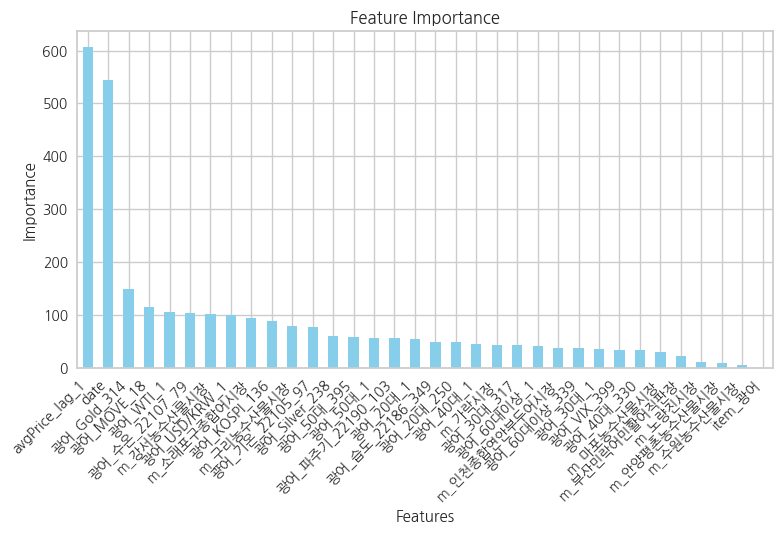

NameError: name 'model' is not defined

In [3]:
df_광어 = pd.read_csv('../../data/features/final_oneHot/광어_price_features_oneHot.csv', encoding='utf-8')
best_model = run_automl_feature_importance(df_광어, "avgPrice")
best_model.get_params()